<center>
    <h1>PyCaret v Traditional Machine Learning Classification Models</h1>
    <h2>Rebecca Hinrichs</h2>
    <h4>5 Dec 2022</h4></center>

***

We have been tasked to explore NanoString's CoxMx Spatial Molecular Imager ultra-high resolution tissue images of non-small-cell lung cancer tissue and to classify them according to the company's publicly-available online dataset. We have chosen the `Lung 12` dataset and will use the imager's modeling data in order to classify the tissue samples as one of thirty `fov` or 'Field Of View' classes. We will use a variety of traditional machine learning methods, including Python's 'Multilayer Perceptron' neural network machine learning algorithm, SciKit-Learn's 'Support Vector Machine' machine learning algorithm, as well as its 'Logistic Regressor' and 'Random Forest' machine learning algorithms, and we will compare our results using these four classification techniques against PyCaret's proprietary auto-machine learning model. We will use various model improvement techniques for all of our models in order to determine the best outcome, and will discuss our findings.

***

In [1]:
filename = 'Lung12_exprMat_file.csv'

In [2]:
# EDA Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
%matplotlib inline
from collections import Counter
# Data Pre-Processing Libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.combine import SMOTEENN
# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from libsvm.svmutil import *
from sklearn.svm import SVC
from pycaret.classification import *
# Model Evaluation Metrics Libraries
from scipy.stats import truncnorm
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.metrics import cohen_kappa_score, hamming_loss, log_loss, zero_one_loss, matthews_corrcoef
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, cross_val_score, RepeatedStratifiedKFold
# Suppress version depreciation warnings
import warnings
warnings.filterwarnings('ignore')

***
# *** Exploratory Data Analysis ***
We'll begin our study by evaluating the data in our database. We'll explore the nature of the data collected, its terms of measurements, whether it contains any incomplete records or has any outlier measurements which could affect its overall statistics, and the nature of the classification labels in relationship to one another over the overall database.
<br><br>
**Missing values** (or null values) affect the statistical inferences we'll be making when applying our classification models. For example: if Class A's classification model depends on 3 features but Class B has the ability to be weighed against 5 features, our odds of correctly classifying a Class B label are greater than correctly classifying a Class A label.
<br><br>
**Zero values** behave similarly to null values, but instead of being overlooked, are included as a measurement of value zero. For this reason, we believe it is always good practice to include these questions in our forensics upon data collection, in order that we may include or omit zero or omitted values as relevant to feature classification.
<br><br>
Finally we'll observe the nature of the **classification labels**- for example: are they categorical, ordinal, or continuous (probabilistic)? Are there significant disparities between the classes? The answers to these questions will help us construct the best machine learning model for our data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74025 entries, 0 to 74024
Columns: 982 entries, fov to NegPrb23
dtypes: int64(982)
memory usage: 554.6 MB
None


<<<-------------------------------- REVIEWING DATABASE RECORDS -------------------------------->>>


The database `Lung12_exprMat_file.csv` contains 74025 rows x 982 columns.

The first ten names of its 982 variables (features) are:
fov
cell_ID
AATK
ABL1
ABL2
ACE
ACE2
ACKR1
ACKR3
ACKR4

We can get a snapshot of the first 5 rows of the data available using head().
Since we have a large amount of features, we'll limit it to 20 for demonstration only.
From this small sample we can estimate how each feature has been recorded:

   fov  cell_ID  AATK  ABL1  ABL2  ACE  ACE2  ACKR1  ACKR3  ACKR4  ACTA2  \
0    1        0    80   136    93   82   124    108    115    139    145   
1    1        1     0     0     0    0     0      0      0      0      0   
2    1        2     0     0     0    0     0      0      0      0      0   
3   

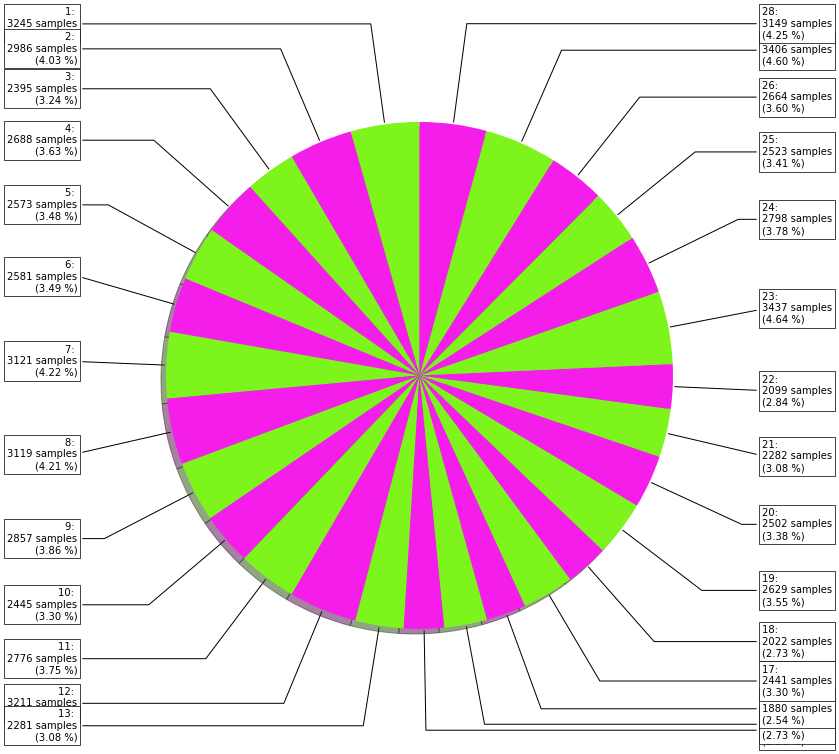


Additionally, we observe the label count distribution in terms of frequency as a histogram:


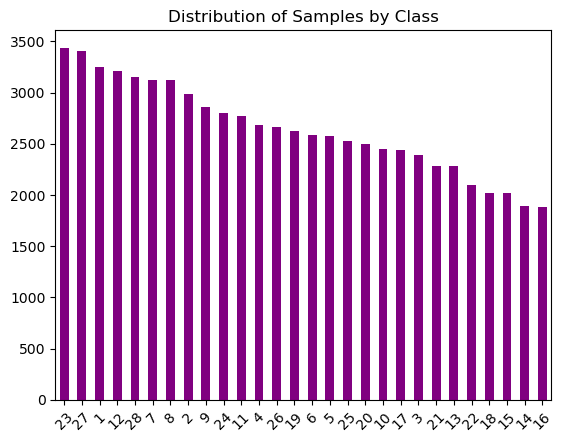



<<<-------------------------------- END OF DATA ANALYSIS -------------------------------->>>




In [3]:
# Function to do a full exploratory data analysis on a single filename
def eda_labels(filename):
    
    # Import data
    data = pd.read_csv(filename)
    
    # Demonstrate dataframe specs
    print(data.info())
    
    # Local variables
    num_rows = data.shape[0]
    num_cols = data.shape[1]
    colnames = [x for x in data.columns]
    
    print('\n\n<<<-------------------------------- REVIEWING DATABASE RECORDS -------------------------------->>>\n\n')
    
    # Observe Data Records
    print(f'The database `{filename}` contains {num_rows} rows x {num_cols} columns.')
    print(f'\nThe first ten names of its {num_cols} variables (features) are:')
    [print(i) for i in colnames[:10]]

    # Summarize the Data
    print('\nWe can get a snapshot of the first 5 rows of the data available using head().')
    if num_cols > 20:
        print('Since we have a large amount of features, we\'ll limit it to 20 for demonstration only.')
        print('From this small sample we can estimate how each feature has been recorded:\n')
        print(data[colnames[0:20]].head(),'\n')
    else:
        print('From this small sample we can estimate how each feature has been recorded:\n')
        print(data.head(),'\n')
    
    # Observe the Data Types
    import numpy as np
    print(f'The data types of each column are \n{data.dtypes}\n')
    class_type = 'string' if (data[colnames[0]].dtype == object) else 'numeric'
    print(f'The class labels are of data type: {class_type}\n')
    
    # Looking for empty values
    vals = ['null','zero']
    for x in vals:
        if x == 'null':
            col_sum = data.isna().sum()
        else:
            col_sum = (data==0).sum()
        print(f'<< ---------- {x} values ---------- >> ')
        print(f'\nThe total number of cells containing {x} values in our data ' \
              f'set is {col_sum.sum()} which is {round(col_sum.sum()/(num_rows*num_cols)*100,2)}% of our total data.\n')
        if col_sum.sum() > 0:
            five_number = [10, 25, 50, 75, 90, 100]
            for i in five_number:
                print(f'{len(col_sum[(col_sum/(num_rows) >= i/100)])} features- ' \
                      f'or {round(len(col_sum[(col_sum/(num_rows) >= i/100)])/num_cols*100,2)}% percent of the dataset- ' \
                      f' contain {i}% or more of their data as {x} ')
            print(f'\nThe remaining ' \
                  f'{len(col_sum[(col_sum/(num_rows) < .1)])} ' \
                  f'{x} values exist among variables which contain under 10% of their data as {x}.\n')
            
    print('\n\n<<<-------------------------------- ANALYZING CLASS DISTRIBUTION -------------------------------->>>\n\n')
    
    # Evaluate label assignment distribution of records
    data_class_dist = data.groupby(colnames[0]).size()
    print('\nThe number of records per class assignment is as follows:')
    print(data_class_dist,'\n')
    
    # Confirm label distribution among record totals
    class_equality = True
    for ea in data_class_dist:
        if ea == (data_class_dist.iloc(0)):
            continue
        else:
            class_equality = False
    if_even = str('an even') if (class_equality == True) else str('an uneven')
    if_equal = 'is' if (data[colnames[0]].count() == num_rows) else 'is NOT'
    print(f'\nGiven these counts, we observe {if_even} ' \
          f'distribution among a total of {len(data_class_dist)} classes,\n\tfrom ' \
          f'{min(data_class_dist)} to {max(data_class_dist)} records apiece.\n')
    print(f'The total class assignment of ' \
          f'{data[colnames[0]].count()} {if_equal} ' \
          f'equivalent to our record total of {num_rows}.\n')
    print('Among the classes, ')
    for y in range(len(data_class_dist)):
        print(f'`{np.unique(data[colnames[0]])[y]:<25}` accounts for ' \
              f'{len(data[data[colnames[0]].values==np.unique(data[colnames[0]])[y]])} or ' \
              f'{round((len(data[data[colnames[0]].values==np.unique(data[colnames[0]])[y]]) / num_rows) * 100,2)}' \
              f'% percent of record total {num_rows}')
    
    # Display label distribution as proportions of data set
    print('\nThis distribution may be observed as a pie chart to describe proportions of the labels:')    
    print("Rows, Columns:", data.shape)
    print('\nClass Distribution among All Variables:')
    Classes = data.groupby(colnames[0]).size()
    labels = Classes.index.values
    sizes = Classes.values
    label_list = []
    for k in range(0,labels.size):
      text = str(labels[k])+': \n'+str(sizes[k])+' samples\n({:,.2f} %)'.format((100*sizes[k]/sum(sizes)))
      label_list.append(text)
    colors = ['#7df51d','#f51de9']
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")
    fig,ax1 = plt.subplots(figsize=(10,10),ncols=1,nrows=1)
    plt.rc('font', size=10)
    wedges, texts = ax1.pie(sizes, shadow=True, colors=colors, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    # Demonstrate label distribution as pie chart
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax1.annotate(label_list[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    plt.show()
    
    # Display label distribution as frequency distribution (histogram)
    print('\nAdditionally, we observe the label count distribution in terms of frequency as a histogram:')
    plt.rcParams.update(plt.rcParamsDefault)  # return font sizes to default
    data[colnames[0]].value_counts().plot(kind='bar', color='purple', title='Distribution of Samples by Class')
    plt.xticks(rotation=45)
    plt.show()
    
    print('\n\n<<<-------------------------------- END OF DATA ANALYSIS -------------------------------->>>\n\n')
            
    return data, class_equality

# Run function on data set and store dataframe and boolean whether classes are imbalanced
data, class_equality = eda_labels(filename)

***
# * Data Pre-Processing *
To begin, we will reserve 10% of our entire dataset for a final test of our prediction model. The remaining 90%, which we will refer to as our *modeling data*, will be the data with which we create our prediction model. This data reservation process is referred to **leave one out cross-validation**, and when done properly, allows us to understand how well our final trained & tested model can generalize, as well as how well it can predict, unseen data. It is important to point out the order with which we must do this. First, the data remains in its native, recorded state as it was imported with the rest of the data. The data is reserved at random selection in order to maintain statistical integrity. Second, it is important to keep the data completely unprocessed before any collinearity or scaling adjustments are performed, in order to ensure the balance of sensitivity and specificity of our final prediction model maintains its integrity. 
<br><br>
Finally, rather than performing any sort of feature selection *before* getting into cross-validation, we propose that performing feature selection *during* cross-validation would allow the selected features to only be derived from the training data and not from the joint pool of both training and validation data. This is particularly important when we are presented with **imbalanced data**, due to the fact that the classifier we intend to work with uses statistical processes detecting entropy in order to model prediction data which exacerbate outlier data by amplifying its impact. In short, balancing our classes will help our model treat *normal* samples as equally as it will treat *relevant* samples, since the largest class contains `23` class references and less than half that amount contain `16`. Being that our proposal implies the relative importance of our minority class, reserving an untouched testing sample immediately before processing our data, and then properly balancing our classes before fitting them to our classifier is imperative in our order of operations.
<br><br>
Therefore, our approach follows these 5-steps *prior* to fitting the data to our model for training:
  - 1) Leave One Participant Out for Cross-Validation
  - 2) Perform Dimensionality Reduction by removing Sparse & Collinear/Correlated Variables
  - 3) Normalize the Data in order to reduce the impact of outlier data points
  - 4) Split the training/testing data 
  - 5) Address imbalanced class data on the training set prior to fitting the model

###### Step 1) Leave One Participant Out for Cross-Validation

In [4]:
# Apply data partitioning technique on dataframe, where 
# PARAMETERS: dataframe assumes any EDA on the full imported data set has already been completed

def reserve_data(dataframe):
    # Reserve 10% of randomized dataset for final test on finalized model
    try:
        print('\n\n<<<---------------------------- BEGIN PREPARING DATA ---------------------------->>>\n\n')
        model_data = dataframe.sample(frac=0.9, random_state=786).reset_index(drop=True)
        reserve_data = dataframe.drop(model_data.index).reset_index(drop=True)  # Remains unprocessed
        print('\tRandomized Data for Modeling:       ' + str(model_data.shape) + '  (rows, columns)')
        print('\tReserved Data for Cross-Validation:  ' + str(reserve_data.shape) + '  (rows, columns)')
        print('\n\n<<<-------------------------- DATA IS READY TO PROCESS -------------------------->>>\n\n')
    except:
        print('\n\n<<<----------- ERROR: There was a problem reserving the data!----------->>>\n\n')
    
    return model_data, reserve_data


# Run function on dataframe to partition data for cross-validation
data_seen, data_unseen = reserve_data(data)



<<<---------------------------- BEGIN PREPARING DATA ---------------------------->>>


	Randomized Data for Modeling:       (66622, 982)  (rows, columns)
	Reserved Data for Cross-Validation:  (7403, 982)  (rows, columns)


<<<-------------------------- DATA IS READY TO PROCESS -------------------------->>>




Our method in performing dimensionality reduction will be to remove collinear data from our modeling data. **Collinear variables** are those which present a highly collinear relationships, exposed by means of a correlation matrix. Highly correlated variables present inflation to our variance because interdependency of variables pull weight from the coefficients of other independent variables in relationship to the output. In other words, in order to define as succint a formula as possible (the linear equation our model will formulate), we must make sure every variable as input is completely independent. We will implement a threshold of $95\%$ collinearity required in order to discard any particular variable as redundant.
<br><br>
**Data scaling** is a valuable technique to fit our data to a normalized interval, and is particularly useful when we can observe a large disparity between the max() and min() values and the large gaps between our averages, we could benefit by scaling our data into an interval described by standard deviations rather than discrete measurements. Normalizing our training set decreases the effect of 'noise' in order to achieve as high precision as possible.
###### Steps 2-3) Perform Dimensionality Reduction & Normalize the Data

In [5]:
# Apply data pre-processing techniques on dataframe, where 
# PARAMETERS: dataframe assumes any EDA on the imported data set has already been completed
#             class_equality is a boolean representing whether class distribution is equal, 
#             convert_class default==True to convert class to dummy variables UNLESS specified False

def preprocess_data(dataframe, class_equality, convert_class=True):
    # Function-Imperative Libraries
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    # Local Variables
    data = dataframe
    num_rows = data.shape[0]
    num_cols = data.shape[1]
    colnames = [x for x in data.columns]
    
    try:
        print('\n\n<<<---------------------------- PRE-PROCESSING MODEL DATA ---------------------------->>>\n\n')

        # Store class variable assignments and reassign dummy variables if needed
        if convert_class == True and not (classes.isdigit() for classes in data[colnames[0]]):
            print('\n<< ---------- CONVERTING CLASS VARIABLE TYPE ---------- >> \n')
            print('Converting our variables from strings to reference variables '\
                 '\n\tallows us to use numeric placeholders for our preprocessing algorithms.\n')
            # Replace string values in dataset with dummy reference Labels
            dummy_vars = list(range(len(np.unique(data[colnames[0]]))))
            print('Class variable conversion in progress...')
            for var in range(len(dummy_vars)):
                print(f'`{np.unique(data[colnames[0]])[var]:<22}` is being assigned reference variable ' \
                      f'  {dummy_vars[var]}')
            data[colnames[0]] = data[colnames[0]].replace(np.unique(data[colnames[0]]),dummy_vars)
            print('\nClass variables have been converted successfully!\n')
            # Confirm dummy variable counts equate to original label counts
            print('Class counts are now as follows:\n', data.groupby(colnames[0]).size(),'\n')
            data_classes = [convert_class, np.unique(data[colnames[0]]), dummy_vars]  # True = was converted

#         # Create column transformer to protect categorical features of class labels identified by integers
#         column_transformer = make_column_transformer(
#             (OneHotEncoder(), data[colnames[0]]),
#             remainder='passthrough')
        
        # Define dependent (Y) and independent (X) variables to prepare for our model F where F(X)=y
        y = data[colnames[0]]
        X = data.drop([colnames[0], colnames[1]], axis=1)
        
#         # Ensure train/test X is fitted to target variables as data points rather than distributions
#         X = column_transformer.fit_transform(X)
#         X = pd.DataFrame(data=X, columns=column_transformer.get_feature_names_out())

        # Comparing statistics
        print('\n<< ---------- PRESENTING PRE-SCALED STATISTICAL ANALYSIS ---------- >> \n')
        print('\nFirst, we\'ll get a summarized statistics report of each feature using describe().')
        print('From this summary we can witness the numerical differences between the variables.\n')
        if num_cols > 20:
            print('We\'ll keep this under 20 columns again for demonstrative purposes.\n')
            print(data[colnames[2:20]].describe(),'\n')
        else:
            print(data.describe(),'\n')
        print('The maximum data point recorded is', X.values.max())
        print('The minimum data point recorded is', X.values.min())
        print('The average of all data points is', X.values.mean(),'\n')

        # Scale the data to achieve optimal numerical precision
        print('\n<< ---------- SCALING THE DATA ---------- >> \n')
        print('\nProcessing variables through `StandardScaler` normalization technique...')
        print('........processing........\n')
        X_cols = list(X.columns)
        scaler = StandardScaler().fit(X)
        scaled_data = scaler.transform(X)
        X = pd.DataFrame(scaled_data, columns=X_cols)
        # Confirm the scaling was effective
        if num_cols > 20:
            print('We\'ll keep this under 20 columns again for demonstrative purposes...\n')
            print(X[colnames[2:20]].head())
        else:
            print(X.head())
        print(f'Success! The data has been normalized.\n')

        # Check for variable collinearity & remove excess features
        print('\n<< ---------- DETECTING COLLINEAR VARIABLES ---------- >> \n')
        var_threshold = VarianceThreshold(threshold = 0).fit(X)
        X_cols = X.columns[var_threshold.get_support()]
        X = var_threshold.transform(X)
        X = pd.DataFrame(X, columns = X_cols)
        # Define threshold of collinearity to be at least 90-percent
        threshold = 0.975
        print(f'\nRemoving sparse features and searching for collinearity above {threshold*100}%...')
        # Detect correlation between variables using correlation matrix
        print('........processing........')
        print('........this usually takes some time........\n')
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
        print(f'The following upper correlation matrix was returned:\n {upper.head()}\n')
        # Select columns which have correlations above specified threshold
        cols_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        print('There are %d collinear columns being removed....' % (len(cols_to_drop)))
        # Remove collinear columns from dataset
        X = X.drop(cols_to_drop, axis=1)
        print(f'Success! All collinear variables have been eliminated.\n')

        # Comparing statistics
        print('\n<< ---------- PRESENTING POST-SCALED STATISTICAL ANALYSIS ---------- >> \n')
        print('\nWe can now get a NEW summarized statistics report of the post-processed data using describe().')
        print('From this summary we can witness the numerical differences between the variables.')
        if num_cols > 20:
            print('We\'ll keep this under 20 columns again for demonstrative purposes.\n')
            print(data[colnames[2:20]].describe(),'\n')
        else:
            print(data.describe(),'\n')
        print('\nThe maximum post-processed data point is', X.values.max())
        print('The minimum post-processed data point is', X.values.min())
        print('The average of all post-processed data points is', X.values.mean(),'\n')
        print(f'`X` contains all of the post-processed data values as a {X.shape[0]} by {X.shape[1]} data frame.')
        print(f'`y` contains the post-processed class labels for each record as a {y.shape[0]} list of values.\n')

        print('\n\n<<<-------------------------------- DATA IS READY FOR FITTING -------------------------------->>>\n\n')

        return X, y
    except:
        print(f'\n\n<<<----------- Target variable `{colnames[0]}` was not found!----------->>>\n\n')


# Run function on dataframe and boolean variable to prepare data to fit model
X, y = preprocess_data(data_seen, class_equality)



<<<---------------------------- PRE-PROCESSING MODEL DATA ---------------------------->>>



<< ---------- PRESENTING PRE-SCALED STATISTICAL ANALYSIS ---------- >> 


First, we'll get a summarized statistics report of each feature using describe().
From this summary we can witness the numerical differences between the variables.

We'll keep this under 20 columns again for demonstrative purposes.

               AATK          ABL1          ABL2           ACE          ACE2  \
count  66622.000000  66622.000000  66622.000000  66622.000000  66622.000000   
mean       0.095884      0.158686      0.157350      0.114497      0.155759   
std        1.687686      3.118039      2.710344      2.139955      3.040775   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.0000

There are 885 collinear columns being removed....
Success! All collinear variables have been eliminated.


<< ---------- PRESENTING POST-SCALED STATISTICAL ANALYSIS ---------- >> 


We can now get a NEW summarized statistics report of the post-processed data using describe().
From this summary we can witness the numerical differences between the variables.
We'll keep this under 20 columns again for demonstrative purposes.

               AATK          ABL1          ABL2           ACE          ACE2  \
count  66622.000000  66622.000000  66622.000000  66622.000000  66622.000000   
mean       0.095884      0.158686      0.157350      0.114497      0.155759   
std        1.687686      3.118039      2.710344      2.139955      3.040775   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000 

With our data successfully scaled and cleansed of irrelevant variables, we are ready to partition our data for training and testing. We will then address any class imbalance issue using our training data in order to build our model as free from bias as possible.<br>
###### Step 4) Split the training/testing data

In [6]:
# Apply data pre-processing techniques on partitioned variables, where 
# PARAMETERS: X_term refers to all variables in the dataset which are features to measure class
#             y_term refers to all class labels (target variables) in the dataset

def split_data(X_term, y_term):    
    try:
        # Build the model using 20% of the data set for testing, 80% for training
        print('\n\n<<<-------------------------- DESIGNATING TRAIN/TEST DATA -------------------------->>>\n\n')
        X_train, X_test, y_train, y_test = train_test_split(X_term, y_term, 
                                                            test_size=0.2,     # test size of 20% (rest:train)
                                                            random_state=101,  # random state = 101
                                                            stratify=y_term)   # distribute shuffling
        # Summary of Model Parameters
        print('We will train our model to predict the Class to which each record belongs based on its features.')
        print()
        print('Our training model has', X_train.shape[0], 'rows x', X_train.shape[1], 'columns ' \
             'representing data points collected.\n' \
              'These make a total of', X_train.shape[0]*X_train.shape[1],'independent (x) inputs to our model,\n' \
              'delivering', y_train.shape[0], 'dependent (y) linear outputs from some function F(x)=y.')
        print('Our training model hosts',round((X_train.shape[0]/data.shape[0]*100),2), '% of the model data.')
        print()
        print('Our testing model has', X_test.shape[0], 'rows x', X_test.shape[1], 'columns ' \
             'representing data points collected.\n' \
              'These make a total of', X_test.shape[0]*X_test.shape[1],'independent (x) inputs to our model,\n' \
              'delivering', y_test.shape[0], 'dependent (y) linear outputs from proposed function F(x)=y.')
        print('Our testing model hosts',round((X_test.shape[0]/data.shape[0]*100),2), '% of the model data.\n')


        # Observe percentage of label distribution per training / testing samples
        print('\n<< ---------- PRESENTING MODEL DATA DISTRIBUTIONS ---------- >> \n')
        print(f'Total sample records in dataset: {len(X_train+X_test)}\n')
        unique, frequency = np.unique(y_train, return_counts = True)
        print(f'Class distribution for {len(y_train)} training samples:')
        print(f'Class\tCount\tPercent')
        for u, f in zip(unique, frequency):
            print(f'{u:>5}\t{f:>5}\t{f/frequency.sum():.1%}')
        print()
        unique, frequency = np.unique(y_test, return_counts = True)
        print(f'Class distribution for {len(y_test)} testing samples:')
        print(f'Class\tCount\tPercent')
        for u, f in zip(unique, frequency):
            print(f'{u:>5}\t{f:>5}\t{f/frequency.sum():.1%}')
        print('\n\n<<<---------------------- TRAINING MODEL IS READY FOR FITTING ---------------------->>>\n\n')
    except:
        print('\n<< ---------- ERROR: The data shapes are mismatched! ---------- >> \n')
    
    return X_train, X_test, y_train, y_test

# Run function on X & y variables to split data into training and testing sets
X_train, X_test, y_train, y_test = split_data(X, y)



<<<-------------------------- DESIGNATING TRAIN/TEST DATA -------------------------->>>


We will train our model to predict the Class to which each record belongs based on its features.

Our training model has 53297 rows x 95 columns representing data points collected.
These make a total of 5063215 independent (x) inputs to our model,
delivering 53297 dependent (y) linear outputs from some function F(x)=y.
Our training model hosts 72.0 % of the model data.

Our testing model has 13325 rows x 95 columns representing data points collected.
These make a total of 1265875 independent (x) inputs to our model,
delivering 13325 dependent (y) linear outputs from proposed function F(x)=y.
Our testing model hosts 18.0 % of the model data.


<< ---------- PRESENTING MODEL DATA DISTRIBUTIONS ---------- >> 

Total sample records in dataset: 66622

Class distribution for 53297 training samples:
Class	Count	Percent
    1	 2337	4.4%
    2	 2148	4.0%
    3	 1718	3.2%
    4	 1946	3.7%
    5	 1831	3.4%

A **class imbalance problem** is presented when there is a significant disparity among classification data. The disparity can be observed by analyzing the data's class distribution. Because most machine learning algorithms utilize statistical analyses which may potentially ignore underrepresented classes among our target variables (e.g. the chi-squared test, among others), they depend upon equally or near-equally-weighted classification probabilities in order to properly weigh predictions against relevant features. We will attempt to achieve an optimal class balancing using a handful of techniques available from Python's `scikit-learn` and `imblearn` libraries by:
  - applying **random oversampling** of the training data in order to introduce interpolated examples of underrepresented classes by enforcing random duplication of data points specifically away from decision boundaries of class specifiers, allowing a more generalized overlook of all data points representing shared features as opposed to specific representative data. We'll utilize the `Synthetic Minority Over-sampling Technique (SMOTE)` technique, whose <a href='https://arxiv.org/abs/1106.1813'>authors recommend</a> combining with undersampling the majority class. Applying this oversampling technique *after* setting aside our unseen data reserve for cross-validation but *before* fitting our classifier prediction model is key to keep ourselves from overfitting our model and allowing a more accurate predictor of new data
  - applying a **random undersampling** technique, which involves randomly deleting examples from the majority classes, using `Edited Nearest Neighbors (ENN)` in combination with SMOTE (order does not matter, since SMOTE is applied to minority classes, and ENN is applied to the majority class); the ENN method downsamples the majority and minority classes, removing examples in all classes of the training set which are misclassified on the basis of their nearest neighbors; the combination of both oversampling via SMOTE and undersampling via ENN is referred to as **random resampling** and is available in `scikit-learn`'s library as `SMOTEENN`; for more, one may refer to <a href='https://dl.acm.org/doi/10.1145/1007730.1007735'>this publication</a>
  - removing statistically **redundant features** using `Principal Component Analysis (PCA)`
  - implementing a **cross validation** technique on the training data alone in order to avoid data leakage into the testing data
  
We expect the combination of these techniques to improve the overall sensitivity and specificity of our trained model.
<br>
###### Step 5) Address imbalanced class data on the training set prior to fitting the model

In [7]:
# Apply class balancing techniques on partitioned variables, where 
# PARAMETERS: X_train_term refers to all variables in the Training Set which are features
#             y_train_term refers to all class labels (target variables) in the Training Set
#             class_equality_term refers to the boolean resulting from function preprocess_data()

def balance_classes(X_train_term, y_train_term, class_equality_term):
    # Check if class distribution presents an imbalance problem & if so, solve it
    if class_equality == False:

        # If class disparity is over 10%, apply balancing techniques
        class_dist = y_train_term.value_counts()
        if (max(class_dist) - min(class_dist)) / sum(class_dist) > .1:

            try:
                # Balance the data
                print('\n<< ---------- ADDRESSING CLASS IMBALANCE PROBLEM ---------- >> \n')
                print(f'\nBecause we observe a 10% or greater disparity between our class distributions,\n' \
                      f'\twe will apply a balancing technique in order to promise a more accurate model fitting.\n')

                # Combine over- and under-sampling as Resampling Method
                resampler = SMOTEENN(sampling_strategy='all',                          # upsample minority class
                                     random_state=42,                                  # set seed of random state generator
                                     smote=SMOTE(sampling_strategy='not majority'),                 # default: SMOTE() oversampling
                                     enn=EditedNearestNeighbours(sampling_strategy='not minority'), # default: ENN() undersampling
                                     n_jobs=1)                                         # default: 1 CPU core used during cross-val loop
                which_sample = str('class') if len(class_dist)==2 else str('classes')
                print(f'\nResampling the data: oversampling minority {which_sample} via SMOTE technique...' \
                      f'\n\t\t     downsampling majority {which_sample} via ENN technique...\n')                

                # Resample training data using SMOTE & ENN techniques
                X_rsampled, y_rsampled = resampler.fit_resample(X_train_term, y_train_term)
                print(f'Resampled Data shape: %s ' % Counter(y_rsampled),'\n')

                # Plot the new distribution
                colors = plt.cm.viridis(colors.Normalize(0, 1))
                labels = [x for x in y_rsampled.value_counts().index]
                plt.bar(labels, y_rsampled.value_counts(), color=colors)
                plt.title('Distribution of Data by Class',
                    fontsize='large',
                    fontweight='bold',
                    style='italic',
                    family='monospace')
                plt.xticks(labels, [x for x in class_dist])
                plt.xlabel('Value of y (Class)')
                plt.ylabel('Number of y in X (Frequencies)')
                plt.show()

                # Summarize the new distribution
                print(f'\nSuccess! Class counts are now as follows:\n')
                counter = Counter(y_rsampled)
                for k, v in counter.items():
                    per = v / len(y_rsampled) * 100
                    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

                # Display resampled distribution of numerical values per class
                if which_sample == 'class':
                    classA, classB = 0, 1
                    fig, ax = plt.subplots(1,2)
                    ax[0].set_title(f'Former-Majority Class: {classA}')
                    ax[0].plot(y_rsampled[y_rsampled==classA], X_rsampled[y_rsampled==classA].values)
                    ax[1].set_title(f'Former-Minority Class: {classB}')
                    ax[1].plot(y_rsampled[y_rsampled==classB], X_rsampled[y_rsampled==classB].values)
                    fig.suptitle('Resampled Data for Training Model')
                    fig.tight_layout()
                    plt.show()                

                print('\t\t...The class data has been effectively balanced...\n')
                print('\n\n<<<---------------------- TRAINING MODEL IS READY FOR FITTING ---------------------->>>\n\n')
                
                return X_rsampled, y_rsampled

            except:
                print('\n<< ---------- ERROR: There was a problem during balancing ---------- >> \n')
        else:
            print('\n\n\t<<<---------------- CLASS IMBALANCE IS LESS THAN 10% ------------------>>>')
            print('\n\t\tSignificance is under the threshold; no balancing is needed!\n\n')
            print('\n\n<<<---------------------- TRAINING MODEL IS READY FOR FITTING ---------------------->>>\n\n')
            
            return X_train_term, y_train_term
    else:
        print('\n\n\t<<<---------- NO CLASS IMBALANCE PROBLEM FOUND! ---------->>>\n\n')
        print('\n\n<<<---------------------- TRAINING MODEL IS READY FOR FITTING ---------------------->>>\n\n')
        
                
# Run function on training data to solve any class imbalance problem   
X_train, y_train = balance_classes(X_train, y_train, class_equality)



	<<<---------------- CLASS IMBALANCE IS LESS THAN 10% ------------------>>>

		Significance is under the threshold; no balancing is needed!




<<<---------------------- TRAINING MODEL IS READY FOR FITTING ---------------------->>>




In [8]:
X_train_copy, X_test_copy, y_train_copy, y_test_copy = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
X_train, X_test, y_train, y_test = X_train_copy.copy(), X_test_copy.copy(), y_train_copy.copy(), y_test_copy.copy()

***
# *** Machine Learning ***
With our training data sufficiently balanced, cleansed of noise and irrelevant variables, we will visit model-specific pre-fitting specifications in order to train our models for optimum efficiency.

***
### * Support Vector Machine Classification * 
We will be using `Support Vector Classifier (SVC)`, a Support Vector Machine (or SVM) classification algorithm which predicts output based on a system of inputs. The algorithm requires that each record in the data is composed as a vector of real numbers, and just like a neural network, the algorithm receives each vector as a series of inputs via an activation function and calculates the weights of the inputs as scalars in a series of nonlinear regression formulas. The SVC then delivers the output as input to the next set of formulas, sifting the data through layers of output/input computations by taking the dot product each time with the corresponding scalars (weights) in the layer, and redefining its internal equations automatically via a backpropagation algorithm in order to minimize any marginal error found during computation of established formulas and new weights introduced via the input. Accordingly, we can more correctly assign labels of the target variable to new, incoming inputs as the model obtains and computes more data (i.e. 'learns'). 
<br><br>
The choice of a kernel approximation greatly affects the accuracy of the SVM, due to the nature of the amplification of the optimization process and the somewhat delicate nature of the the model's complexity. An overly simplified model, for example, will not take more complex features into account, and will easily underfit the data. Adversely, an overly complex model may run the risk of overfitting the data. The models differ in terms of complexity by mathematical approach: the nonlinear kernel, for example, in the case of the RBF Kernel, maps samples into a higher-dimensional space in order to slice the features in terms of relevance at a more complex model (for example: classifying 'snowy' or 'sunny' on a mountain is best done in a 3D space by a hyperplane rather than a flat plane by a linear approach). Additionally, the polynomial kernel has more hyperparameters than the RBF kernel, while the linear and sigmoid kernels behave differently entirely for certain parameters and are invalid for others.
<br><br>
The only other yet important consideration in fitting an SVM model is to cross-validate the support vectors during the training process. This is independent of our overall cross-validation we implemented at the outset of our project by reserving a fraction of unseen data. The algorithmic cross-validation technique we will use searches for the best penalty parameter $C$ and kernel parameter $\gamma$ to apply to our kernel approximation model. In layman's terms, we might call $C$ the overreach allowance and $\gamma$ the incremental retrace while the algorithm searches for the MMH (Maximum Margin Hyperplane). The MMH works like an asymptote between classes, and the support vectors on either side of an MMH are the borders for each class. Allowing too big a $C$ or too small a $\gamma$ (or vice versa) depletes sensitivity and specificity by overfitting or underfitting the training model. Therefore finding reasonable $C$ and $\gamma$ parameters for our data will be crucial to accuracy.
<br><br>
Therefore our approach to pre-fitting our model will be as follows:
  - rescale the data to a **narrower interval**. The authors <a href='https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf'>recommend</a> scaling the data before fitting it to both the training and testing sets, which we had done, but they also recommend to fit the scaling within a narrow interval range of $[-1,+1]$ or $[0,1]$; recall that our post-processing min and max are $[-1.65, 173]$, far better than our pre-processed min and max but still significant in disparity. So we will attempt this important adjustment prior to fitting our training model, because, as the authors also point out in the `LIBSVM` documentation, accuracy would be severely decreased were we to scale the training and testing sets separately,
  - choose an **appropriate kernel approximation** model. Because our number of features is not very large, we can avoid the overly simplistic linear kernel, and because we are interested in a narrow interval of numerical data points rather than continuous, we would find the RBF best-suited for our application. As the authors point out, when the number of instances is greater than the number of features, as is our case (particularly after performing dimensionality reduction), nonlinear kernals (mapping the data to higher dimensional spaces) is typically preferred and significantly faster than the default built-in method,
  - implementing a **cross validation** technique on the training data alone in order to avoid data leakage into the testing data. Since we cannot know beforehand the best values for $C$ and for $\gamma$ until our algorithm runs through the dataset, we will have to perform hyperparameter tuning using cross-validation grid-search during performance evaluation of the training set. We will try exponentially growing sequences of $C$ and $\gamma$ in order to identify good parameters.
  
We expect the combination of these techniques to improve the overall sensitivity and specificity of our trained model.
<br>
###### Step 1) Attempt to rescale the data to a narrower interval

In [9]:
# Collect original, pre-split X,y values for SVM-fitting
X_SVM, y_SVM = X.copy(), y.copy()

# Attempt rescaling to interval [-1,1] before split on BOTH test/train data (for SVM)
max_abs_scaler = MaxAbsScaler()  # this preprocessor scales data to [-1,1] already centered at 0
X_SVM_maxabs = max_abs_scaler.fit_transform(X_SVM)

# Re-split the data through train/test/split function
X_SVM_train, X_SVM_test, y_SVM_train, y_SVM_test = train_test_split(X_SVM_maxabs, y_SVM, 
                                                            test_size=0.2,     # test size of 20% (rest:train)
                                                            random_state=101,  # random state = 101
                                                            stratify=y_SVM)   # distribute shuffling

# Re-process new training set through balancing function as needed
X_SVM_train, y_SVM_train = balance_classes(X_SVM_train, y_SVM_train, class_equality)



	<<<---------------- CLASS IMBALANCE IS LESS THAN 10% ------------------>>>

		Significance is under the threshold; no balancing is needed!




<<<---------------------- TRAINING MODEL IS READY FOR FITTING ---------------------->>>




###### Step 2) Choose an appropriate kernel approximation model

In [10]:
# The SVC Class from Sklearn: demonstrating the default parameters
# defaults = SVC(*, 
#     C=1.0,                          # The regularization parameter
#     kernel='rbf',                   # The kernel type used 
#     degree=3,                       # Degree of polynomial function 
#     gamma='scale',                  # The kernel coefficient
#     coef0=0.0,                      # If kernel = 'poly'/'sigmoid'
#     shrinking=True,                 # To use shrinking heuristic
#     probability=False,              # Enable probability estimates
#     tol=0.001,                      # Stopping crierion
#     cache_size=200,                 # Size of kernel cache
#     class_weight=None,              # The weight of each class
#     verbose=False,                  # Enable verbose output
#     max_iter=- 1,                   # Hard limit on iterations
#     decision_function_shape='ovr',  # One-vs-rest or one-vs-one
#     break_ties=False,               # How to handle breaking ties
#     random_state=None               # Random state of the model
# )

# Building and training our model
SVC_model = SVC()
SVC_model.fit(X_SVM_train, y_SVM_train)

# Making predictions with our data
predictions = SVC_model.predict(X_SVM_test)
print('Accuracy using SVC default parameters:', accuracy_score(y_SVM_test, predictions))

Accuracy using SVC default parameters: 0.09365853658536585


###### Step 3) Implement cross-validation grid-search for parameter estimation

In [ ]:
# Finding the best hyperparameters
params = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

clf = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=1
)

clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


***
### * PyCaret Classification * 


In [ ]:
from pycaret.clustering import *

exp_clu101 = setup(data_seen, normalize = True, 
                   ignore_features = [data[colnames[0]],data[colnames[1]]],
                   session_id = 123)